### **Proyecto - Aprendizaje automatizado**

* Emmanuel Peto Gutiérrez
* Rodrigo Fernando Velázquez Cruz

En este proyecto se trató el problema de "Playlist Continuation" (Ching-Wei Chen et al., 2018),  usando el análisis de las canciones que provee el API de Spotify. Para esto se replicó el preprocesamiento de los datos que proponen (A. Agarwal et al., 2022), posteriormente se usaron los ensambles de Random Forest, AdaBoost y XGBoost, con una optimización de hiperparámetros usando SMAC3 (Lindauer et al., 2022) y validación cruzada con 5 pliegues para un conjunto de 12 playlist con al menos 200 canciones cada uno.

**Referencias**
* Ching-Wei Chen, Paul Lamere, Markus Schedl, and Hamed Zamani. 2018. Recsys challenge 2018: automatic music playlist continuation. In Proceedings of the 12th ACM Conference on Recommender Systems (RecSys '18). Association for Computing Machinery, New York, NY, USA, 527–528. https://doi.org/10.1145/3240323.3240342

* A. Agarwal, P. G,.(2022) "Playlist Classifier based on Song Features,".IEEE 3rd Global Conference for Advancement in Technology (GCAT), Bangalore, India, 2022, pp. 1-4, https://doi.org/10.1109/GCAT55367.2022.9972120.

* Lindauer, M., Eggensperger, K., Feurer, M. Biedenkapp, A. Deng, D.
 Benjamins, C. Ruhkopf. T. Sass, R., Hutter, F. (2022). "SMAC3: A Versatile Bayesian Optimization Package for Hyperparameter Optimization". Journal of Machine Learning Research.23-54 2022, http://jmlr.org/papers/v23/21-0888.html
__________________________________________________________________

**Ejecución de la libreta**

 La libreta se ejecuta secuencialmente de arriba hacia abajo y en el caso de las celdas donde se realiza la optimización de hiperparámetros se puede omitir la ejecución de esas celdas porque tardan demasiado (esas celdas tienen este aviso), los modelos con los mejores parámetros se encuentran en la siguiente celda a cada una de estas, por eso se pueden omitir.

Repositorio donde se tiene todo lo relacionado a los datasets y el manejo de datos del API de Spotify

In [ ]:
!git clone https://github.com/rodrigofvc/music-recommendations-spotify.git
%cd '/content/music-recommendations-spotify/src/'

Cloning into 'music-recommendations-spotify'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 115 (delta 58), reused 89 (delta 36), pack-reused 0
Receiving objects: 100% (115/115), 12.54 MiB | 11.27 MiB/s, done.
Resolving deltas: 100% (58/58), done.
/content/music-recommendations-spotify/src


In [ ]:
import numpy as np
import seaborn
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import AdaBoostClassifier
import matplotlib.pyplot as plt
from playlist import Playlist
from df_to_class import read_playlist
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [ ]:
!pip install xgboost
!pip install smac
!pip install scikit-plot
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import scikitplot as skplt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.6/147.6 kB 4.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 88.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 111.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 108.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 6.1 MB/s eta 0:00:00
  Creat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from ConfigSpace import Categorical, Configuration, ConfigurationSpace, Float, Integer
from sklearn.model_selection import cross_val_score
from smac import HyperparameterOptimizationFacade, Scenario

Indices de las características


In [ ]:
danceability_index = 0
energy_index = 1
key_index = 2
loudness_index = 3
mode_index =  4
speechiness_index = 5
acousticness_index = 6
instrumentalness_index = 7
liveness_index =  8
valence_index =  9
tempo_index = 10
duration_ms_index = 11
time_signature_index = 12
popularity_track_index = 13
popularity_album_index =  14
popularity_artist_index = 15


In [ ]:
# Obtiene las características de una canción
def proyeccion_unitaria(columnas, cancion):
    lista = []
    for c in columnas:
        lista.append(cancion.features[c])
    return lista

In [ ]:
# Transforma un conjunto de objetos de tipo playlist a arreglos X e Y.
def transforma_playlist(cs, playlists):
    X_list = []
    y_list = []
    for i in range(len(playlists)):
        pl = playlists[i]
        for song in pl.tracks:
            X_list.append(proyeccion_unitaria(cs, song))
            y_list.append(pl.id)
    return (np.array(X_list), np.array(y_list))

Obten el conjunto de 12 playlist

In [ ]:
Playlist.n_playlist = 0
proy = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
        'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
        'duration_ms', 'time_signature', 'popularity_track', 'popularity_album', 'popularity_artist']
datasets = ['dataset/mpd.slice.0-999-features-v2.json']
X = np.empty((1,16))
Y = np.empty((1,))
playlist_obj = []
for dataset in datasets:
    playlist_set = read_playlist(dataset)
    playlist_set = [p for p in playlist_set if p.id < 12]
    playlist_obj = playlist_set
    x, y = transforma_playlist(proy, playlist_set)
    X = np.concatenate((X, x))
    Y = np.concatenate((Y, y))
X = X[1:,:]
y = Y[1:]
X.shape, y.shape

((2618, 16), (2618,))

Grafica la cantidad de artistas que aparecen en cada par de playlist, esto nos sirve para saber que tan complicado podría ser clasificar cada canción en la playlist que debería ser, debido a que podría pertenecer a más de una playlist.

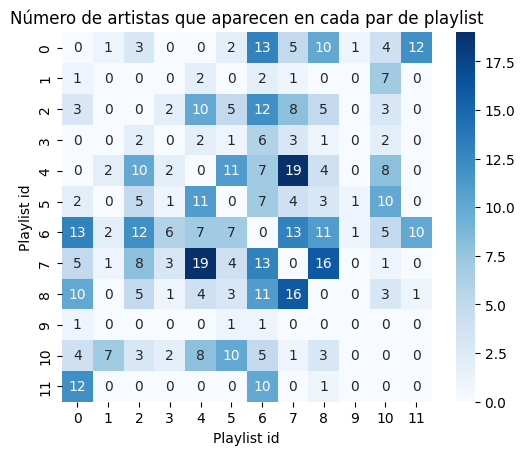

In [ ]:
def plot_matrix_overlap(playlists):
    n = len(playlists)
    m = np.zeros((n, n))
    for i, p in enumerate(playlists):
        artists_p = [t.artist_name for t in p.tracks]
        artists_p = list(set(artists_p))
        for j, p_ in enumerate(playlists):
            if j == i:
                continue
            overlap = [t.artist_name for t in p_.tracks if t.artist_name in artists_p]
            overlap = list(set(overlap))
            overlap = int(len(overlap))
            m[i][j] = overlap
            m[j][i] = overlap
    ax = seaborn.heatmap(m, xticklabels=range(0,12), yticklabels=range(0,12), annot=True, square=True, cmap='Blues')
    ax.set_xlabel('Playlist id')
    ax.set_ylabel('Playlist id')
    plt.title('Número de artistas que aparecen en cada par de playlist')
    plt.show()
plot_matrix_overlap(playlist_obj)

Métodos para preprocesamiento

In [ ]:
# Convierte milisegundos a minutos
def ms_a_minutos(X_in):
    X_in[:,duration_ms_index] = (X_in[:,duration_ms_index] / 1000) / 60

In [ ]:
def normaliza(X_in):
    transformer = StandardScaler().fit(X_in)
    XN = transformer.transform(X_in)
    return transformer, XN

In [ ]:
# Encuentra la variable de interestingness
def interesting(X_int):
    I = np.zeros((X_int.shape[0], 1))
    I = X_int[:, loudness_index] + X_int[:, tempo_index] + (X_int[:, energy_index] * 100) + (X_int[:, danceability_index] * 100) + (X_int[:, acousticness_index] * 100)
    X_int = np.concatenate((X_int, I.reshape(-1,1)), axis=1)
    return X_int

In [ ]:
# Calcula la nueva variable de popularidad
def calcula_popularidad_index(X_in):
    I = np.zeros((X_in.shape[0], 1))
    I = 3*X_in[:, popularity_track_index] + 2*X_in[:, popularity_artist_index] + X_in[:, popularity_album_index]
    X_in = np.concatenate((X_in, I.reshape(-1,1)), axis=1)
    return X_in

In [ ]:
# Asigna 0.1 a los valores en speechiness que pasan el umbral
def process_speechiness(X_in):
    rows=np.where(X_in[:,speechiness_index] > 0.1)
    X_in[rows, speechiness_index] = 0.1
    return X_in

In [ ]:
# Asigna 0.1 a los valores en instrumentalness que pasan el umbral
def process_instrumentalness(X_in):
    rows=np.where(X_in[:,instrumentalness_index] > 0.1)
    X_in[rows, instrumentalness_index] = 0.1
    return X_in

Realiza el procesamiento de los datos

In [ ]:
def preprocessing(x_train, x_test):
    ms_a_minutos(x_train)
    ms_a_minutos(x_test)
    x_train = process_speechiness(x_train)
    x_test = process_speechiness(x_test)
    x_train = process_instrumentalness(x_train)
    x_test = process_instrumentalness(x_test)
    x_train = calcula_popularidad_index(x_train)
    x_test = calcula_popularidad_index(x_test)
    x_train = interesting(x_train)
    x_test = interesting(x_test)
    transformer, x_train = normaliza(x_train)
    x_test = transformer.transform(x_test)
    return x_train, x_test

Obten los conjuntos de entrenamiento y prueba

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=30)
X_train.shape, X_test.shape

((1963, 16), (655, 16))

Análisis de correlación, para eliminar variables que no añaden más información

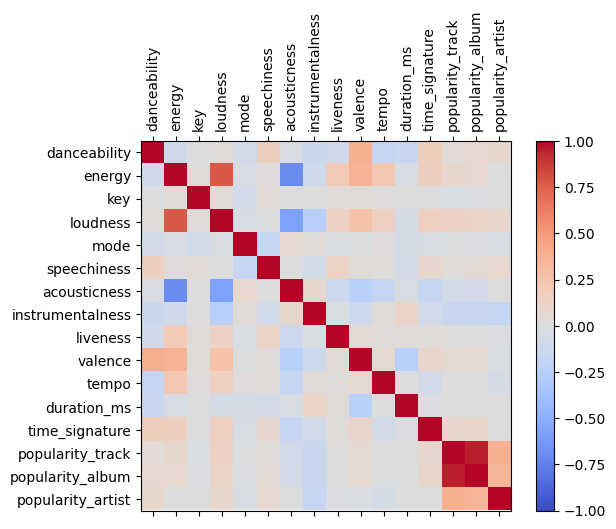

In [ ]:
mc = np.corrcoef(X_train, rowvar=False)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(mc,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,16,1)
labels = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
        'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
        'duration_ms', 'time_signature', 'popularity_track', 'popularity_album',
         'popularity_artist']
ax.set_xticks(ticks, labels=labels)
plt.xticks(rotation=90)
ax.set_yticks(ticks, labels=labels)
plt.show()

Preprocesamiento

In [ ]:
X_train, X_test = preprocessing(X_train, X_test)

Eliminamos variables altamente correlacionadas

In [ ]:
des = [c for c in range(0,16) if c != popularity_album_index and c != popularity_track_index]
X_train = X_train[:, des]
X_test = X_test[:,des]
X_train.shape, X_test.shape

((1963, 14), (655, 14))

Graficar matriz de confusión dado un modelo y el conjunto de prueba

In [ ]:
def plot_confusion_matrix(model, xc_test, yc_test):
  y_pred = model.predict(xc_test)
  cm = confusion_matrix(yc_test, y_pred, labels=model.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
  disp.plot()
  plt.show()

### **Random Forest**

**Optimización con SMAC3 para Random Forest**

La optimización de los hiperparámetros puede tardar horas. En la siguiente celda se encuentra el modelo con los mejores hiperparámetros que encontramos. (Se puede omitir la ejecución de esta celda)

In [ ]:
def train(config: Configuration, seed: int = 0) -> float:
    config_dict = config.get_dictionary()
    classifier = RandomForestClassifier(**config_dict, random_state=seed)
    scores = cross_val_score(classifier, X_train, y_train, cv=5)
    print (f'Validacion cruzada: {scores} para {config_dict}')
    cost = 1 - np.mean(scores)
    return cost


if __name__ == "__main__":
    classifier = RandomForestClassifier()
    hyparameters = {"n_estimators": (100, 2500),
                    "max_depth": (10,40),
                    "min_samples_split": (2,10),
                    "min_samples_leaf": (1,10),
                    }
    configspace = ConfigurationSpace(hyparameters)
    scenario = Scenario(
        configspace,
        n_trials=200,
    )
    smac = HyperparameterOptimizationFacade(scenario, train)
    incumbent = smac.optimize()
    print (incumbent)

[INFO][abstract_initial_design.py:95] Reducing the number of initial configurations from 40 to 5 (max_ratio == 0.25).
[INFO][abstract_initial_design.py:147] Using 5 initial design configurations and 0 additional configurations.
Validacion cruzada: [0.40452261 0.38190955 0.35427136 0.40954774 0.37279597] para {'max_depth': 18, 'min_samples_leaf': 7, 'min_samples_split': 2, 'n_estimators': 608}
[INFO][abstract_intensifier.py:515] Added config ea8fe0 as new incumbent because there are no incumbents yet.
Validacion cruzada: [0.39949749 0.38944724 0.35678392 0.40201005 0.38539043] para {'max_depth': 18, 'min_samples_leaf': 7, 'min_samples_split': 2, 'n_estimators': 608}
Validacion cruzada: [0.39698492 0.3919598  0.36180905 0.4120603  0.38790932] para {'max_depth': 36, 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 1443}
Validacion cruzada: [0.3919598  0.3919598  0.36934673 0.38693467 0.38539043] para {'max_depth': 36, 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimat

Mejor configuración encontrada para Random Forest

In [ ]:
# Validacion cruzada: [0.38676845 0.43002545 0.45547074 0.44897959 0.45153061]
rfc = RandomForestClassifier(n_estimators=1861, max_depth=18, min_samples_leaf=1, min_samples_split=2)
rfc.fit(X_train, y_train)
rfc.score(X_train, y_train), rfc.score(X_test, y_test)

(0.9628120224146715, 0.4442748091603053)

Matriz de confusión usando Random Forest

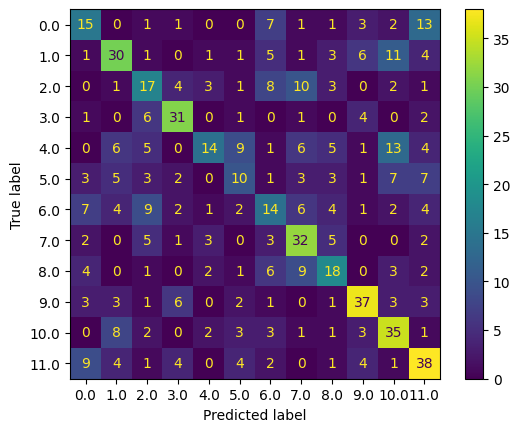

In [ ]:
plot_confusion_matrix(rfc, X_test, y_test)

Evaluación de las métricas para Random Forest

In [ ]:
y_pred = rfc.predict(X_test)
names = ["Playlist " + str(i) for i in range(0,12) ]
print (classification_report(y_test, y_pred, target_names=names))

              precision    recall  f1-score   support

  Playlist 0       0.37      0.36      0.37        44
  Playlist 1       0.48      0.45      0.46        64
  Playlist 2       0.32      0.30      0.31        50
  Playlist 3       0.62      0.67      0.65        46
  Playlist 4       0.48      0.22      0.30        64
  Playlist 5       0.27      0.20      0.23        45
  Playlist 6       0.30      0.29      0.29        56
  Playlist 7       0.45      0.60      0.52        53
  Playlist 8       0.37      0.37      0.37        46
  Playlist 9       0.59      0.60      0.60        60
 Playlist 10       0.45      0.59      0.51        59
 Playlist 11       0.47      0.57      0.52        68

    accuracy                           0.44       655
   macro avg       0.43      0.44      0.43       655
weighted avg       0.44      0.44      0.43       655



Curva ROC para todas las clases usando Random Forest

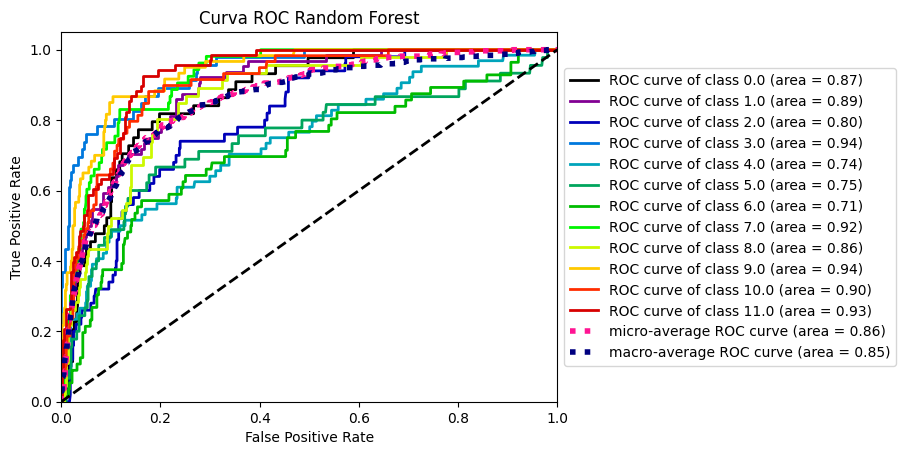

In [ ]:
y_probas = rfc.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, y_probas)
plt.title('Curva ROC Random Forest')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Curva de Precisión-Exhaustivadad para Random Forest

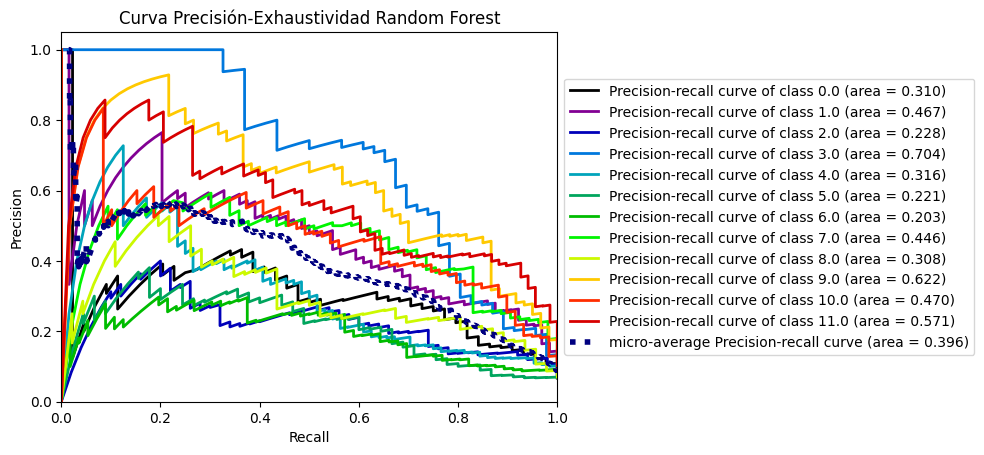

In [ ]:
y_probas = rfc.predict_proba(X_test)
skplt.metrics.plot_precision_recall(y_test, y_probas)
plt.title('Curva Precisión-Exhaustividad Random Forest')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


### **AdaBoosting**

**Optimización con SMAC3 para AdaBoosting**

La optimización de los hiperparámetros puede tardar horas. En la siguiente celda se encuentra el modelo con los mejores hiperparámetros que encontramos. (Se puede omitir la ejecución de esta celda)

In [ ]:
def train(config: Configuration, seed: int = 0) -> float:
    config_dict = config.get_dictionary()
    classifier = AdaBoostClassifier(**config_dict, random_state=seed)
    scores = cross_val_score(classifier, X_train, y_train, cv=5)
    print (f'Validacion cruzada: {scores} para {config_dict}')
    cost = 1 - np.mean(scores)
    return cost


if __name__ == "__main__":
    classifier = AdaBoostClassifier()
    hyparameters = {"n_estimators": (100, 2500),
                    "learning_rate": (0.0001,1.0)
                    }
    configspace = ConfigurationSpace(hyparameters)
    scenario = Scenario(
        configspace,
        n_trials=500,
    )
    smac = HyperparameterOptimizationFacade(scenario, train)
    incumbent = smac.optimize()
    print (incumbent)

[INFO][abstract_initial_design.py:147] Using 20 initial design configurations and 0 additional configurations.
Validacion cruzada: [0.27989822 0.23918575 0.34096692 0.29336735 0.30867347] para {'learning_rate': 0.2669518332177773, 'n_estimators': 1589}
[INFO][abstract_intensifier.py:515] Added config e4427b as new incumbent because there are no incumbents yet.
Validacion cruzada: [0.27989822 0.23918575 0.34096692 0.29336735 0.30867347] para {'learning_rate': 0.2669518332177773, 'n_estimators': 1589}
Validacion cruzada: [0.28753181 0.21119593 0.32824427 0.30357143 0.30102041] para {'learning_rate': 0.6341397034740075, 'n_estimators': 611}
Validacion cruzada: [0.30025445 0.21119593 0.32824427 0.30357143 0.30102041] para {'learning_rate': 0.6341397034740075, 'n_estimators': 611}
Validacion cruzada: [0.27989822 0.23918575 0.34096692 0.29336735 0.30867347] para {'learning_rate': 0.2669518332177773, 'n_estimators': 1589}
Validacion cruzada: [0.26463104 0.26717557 0.32569975 0.32653061 0.3137

Mejor configuración encontrada para AdaBoost

In [ ]:
# [0.35114504 0.37913486 0.43002545 0.38010204 0.3494898 ]
abf = AdaBoostClassifier(n_estimators=249, learning_rate= 0.1212187106160905, random_state=0)
abf.fit(X_train, y_train)
abf.score(X_train, y_train), abf.score(X_test, y_test)

(0.4095771777890983, 0.366412213740458)

Matriz de confusión usando Adaboost

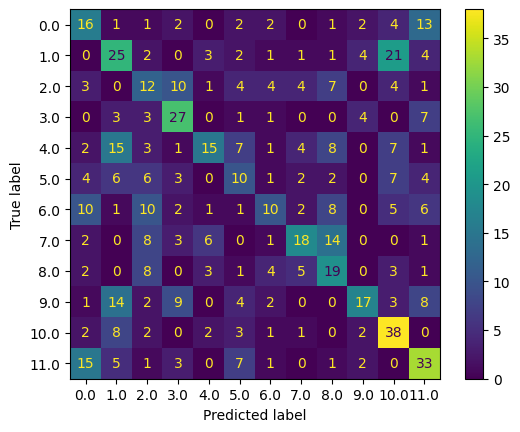

In [ ]:
plot_confusion_matrix(abf, X_test, y_test)

Evaluación de las métricas usando Adaboost

In [ ]:
y_pred = abf.predict(X_test)
names = ["Playlist " + str(i) for i in range(0,12) ]
print (classification_report(y_test, y_pred, target_names=names))

              precision    recall  f1-score   support

  Playlist 0       0.28      0.36      0.32        44
  Playlist 1       0.32      0.39      0.35        64
  Playlist 2       0.21      0.24      0.22        50
  Playlist 3       0.45      0.59      0.51        46
  Playlist 4       0.48      0.23      0.32        64
  Playlist 5       0.24      0.22      0.23        45
  Playlist 6       0.34      0.18      0.24        56
  Playlist 7       0.49      0.34      0.40        53
  Playlist 8       0.31      0.41      0.36        46
  Playlist 9       0.55      0.28      0.37        60
 Playlist 10       0.41      0.64      0.50        59
 Playlist 11       0.42      0.49      0.45        68

    accuracy                           0.37       655
   macro avg       0.38      0.37      0.36       655
weighted avg       0.38      0.37      0.36       655



Curva ROC para Adaboost

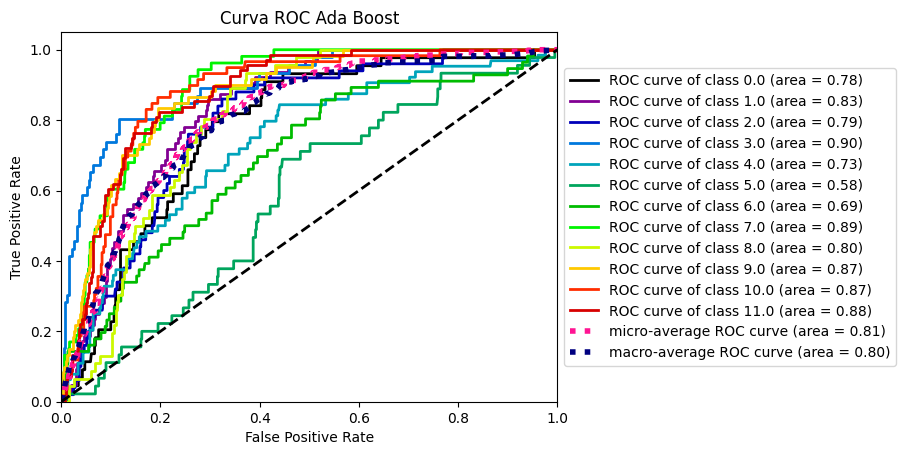

In [ ]:
y_probas = abf.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, y_probas)
plt.title('Curva ROC Ada Boost')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Curva de Precisión exhaustividad para Adaboost

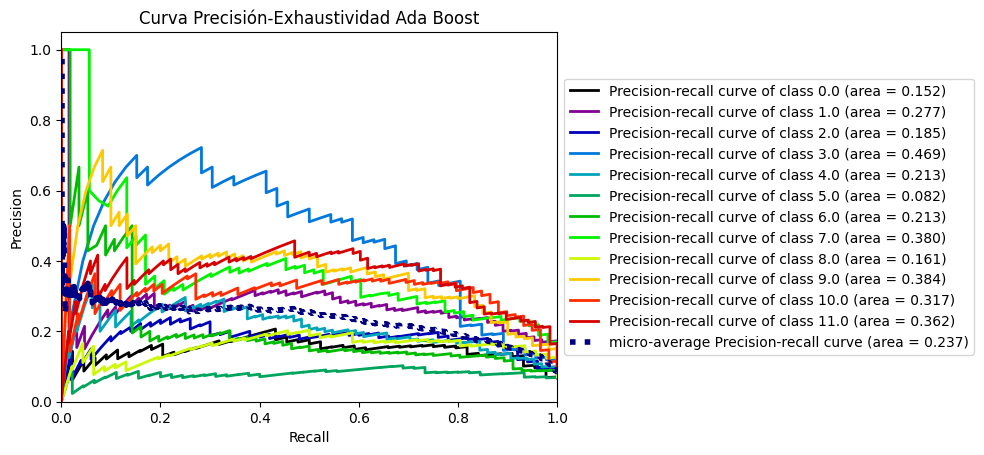

In [ ]:
y_probas = abf.predict_proba(X_test)
skplt.metrics.plot_precision_recall(y_test, y_probas)
plt.title('Curva Precisión-Exhaustividad Ada Boost')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### **XGBoost**

**Optimización con SMAC3 para XGBoost**

La optimización de los hiperparámetros puede tardar horas. En la siguiente celda se encuentra el modelo con los mejores hiperparámetros que encontramos. (Se puede omitir la ejecución de esta celda)

In [ ]:
def train(config: Configuration, seed: int = 0) -> float:
    config_dict = config.get_dictionary()
    classifier = XGBClassifier(**config_dict, random_state=seed)
    scores = cross_val_score(classifier, X_train, y_train, cv=5)
    print (f'Validacion cruzada: {scores} para {config_dict}')
    cost = 1 - np.mean(scores)
    return cost


if __name__ == "__main__":
    classifier = XGBClassifier()
    hyparameters = {"max_depth": (10, 30),
                    "eta": (0.001, 1.0),
                    "nthread": (2,4)
                    }
    configspace = ConfigurationSpace(hyparameters)
    scenario = Scenario(
        configspace,
        n_trials=200,
    )
    smac = HyperparameterOptimizationFacade(scenario, train)
    incumbent = smac.optimize()
    print (incumbent)

Mejor configuración encontrada para XGboost

In [ ]:
# [0.42493639 0.43256997 0.45038168 0.42857143 0.42857143]
xgclf = xgb.XGBClassifier(max_depth=22, eta=0.5912818884869251, nthread=3)
xgclf.fit(X_train, y_train)
xgclf.score(X_train, y_train), xgclf.score(X_test, y_test)

(0.9628120224146715, 0.45190839694656487)

Matriz de confusión usando XGBoost

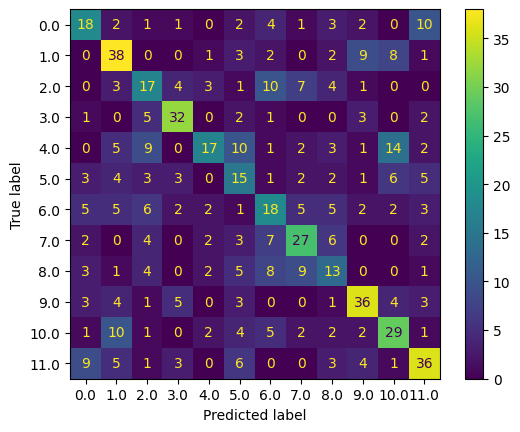

In [ ]:
plot_confusion_matrix(xgclf, X_test, y_test)

Evaluación de las métricas para XGBoost

In [ ]:
y_pred = xgclf.predict(X_test)
names = ["Playlist " + str(i) for i in range(0,12) ]
print (classification_report(y_test, y_pred, target_names=names))

              precision    recall  f1-score   support

  Playlist 0       0.40      0.41      0.40        44
  Playlist 1       0.49      0.59      0.54        64
  Playlist 2       0.33      0.34      0.33        50
  Playlist 3       0.64      0.70      0.67        46
  Playlist 4       0.59      0.27      0.37        64
  Playlist 5       0.27      0.33      0.30        45
  Playlist 6       0.32      0.32      0.32        56
  Playlist 7       0.49      0.51      0.50        53
  Playlist 8       0.30      0.28      0.29        46
  Playlist 9       0.59      0.60      0.60        60
 Playlist 10       0.45      0.49      0.47        59
 Playlist 11       0.55      0.53      0.54        68

    accuracy                           0.45       655
   macro avg       0.45      0.45      0.44       655
weighted avg       0.46      0.45      0.45       655



Curva ROC para XGBoost

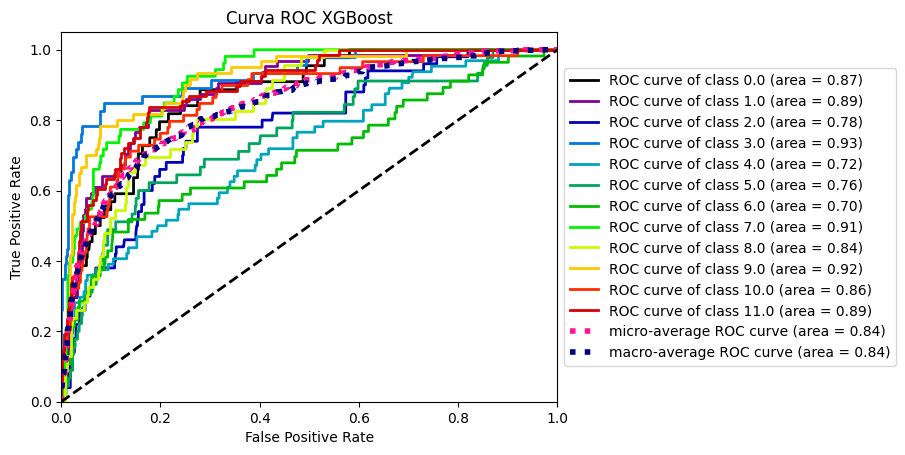

In [ ]:
y_probas = xgclf.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, y_probas)
plt.title('Curva ROC XGBoost')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Curva de Precisión Exhaustivad para XGBoost

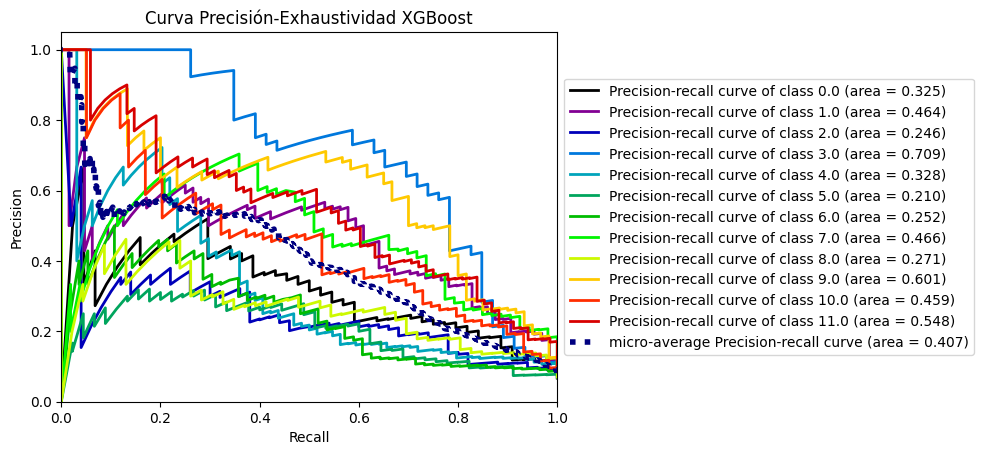

In [ ]:
y_probas = xgclf.predict_proba(X_test)
skplt.metrics.plot_precision_recall(y_test, y_probas)
plt.title('Curva Precisión-Exhaustividad XGBoost')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()